# Forward propogation of uncertainty

In [93]:
import numpy as np
from scipy.interpolate import interp1d
from model import NeoHookeanSolutionGenerator
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.colors import to_rgb

%matplotlib inline

import seaborn as sns
sns.set_theme(style="white")

## Setup for propogation

### Fixed parameters from experiments

In [27]:
# These are fixed, see synthetic_data
omega_val = np.pi
L_val = 2.0
zeta_val = 0.5
nu_f_val = 0.125
# V_wall_val = 1.0

offset = 0.0
res_t = 20
# time stations
time_samples = np.linspace(
    0 + offset / omega_val, (2 * np.pi) / omega_val, res_t, endpoint=False
)
# number of data points
n_samples = len(time_samples)
# y stations
y_stations = np.array([0.2, 0.4, 0.6, 0.8])

In [28]:
# Solution generator
solution_generator = NeoHookeanSolutionGenerator(omega_val, L_val, zeta_val, nu_f_val)

### Model for propogating uncertainty

In [30]:
def generate_signal(
    fluid_velocity_gen, solid_velocity_gen, T=time_samples, y_stations=y_stations
):
    y_profiles = np.zeros((len(y_stations), len(T)))

    for i_station, y_station in enumerate(y_stations):
        solid_velocity = solid_velocity_gen(y_station, T)
        fluid_velocity = fluid_velocity_gen(y_station, T)
        solid_mask = y_station < 0.5
        y_profiles[i_station] = (
            solid_mask * solid_velocity + (1.0 - solid_mask) * fluid_velocity
        )

    return y_profiles


def signal_from_(estimates):
    global solution_generator
    v_f, v_s = solution_generator.generate_velocities_for(*estimates)
    signal = generate_signal(v_f, v_s)
    return signal


def predmodel(q):
    # transpose to get it into the correct shape for interval calculation
    return signal_from_(q).T

### Load chains

In [34]:
chains = pd.read_pickle("chains.pkl")
s2chain = pd.read_pickle("s2chains.pkl")

## Calculate intervals based on sampled chains


### Sampling from chain index

In [35]:
def define_sample_points(n_sample, n_sim):
    if n_sample >= n_sim:
        idx_sample = range(n_sim)
        n_sample = n_sim
    else:
        idx_sample = (np.ceil(np.random.rand(n_sample) * n_sim) - 1).astype(int)

    return idx_sample, n_sample

# See Smith, we assume a normal distribution
def sample_with_errors(s2 , y):
    return y + np.random.standard_normal(y.shape) * np.sqrt(s2)

### Generate interval data

In [96]:
def generate_cp_intervals(
    chain, s2chain, model, n_sample=500
):
    n_sim, n_params = chain.shape
    idx_sample, n_sample = define_sample_points(n_sample, n_sim)

    q = chain[-1]
    y = model(q)
    n_eval_points, n_qoi = np.shape(y)

    # confidence intervals
    ci = np.zeros((n_sample, n_eval_points, n_qoi))
    # prediction intervals
    pi = np.zeros((n_sample, n_eval_points, n_qoi))
    
    for kk, isa in enumerate(idx_sample):
        # parameters
        q = chain[isa]
        # evaluate model
        y = model(q)
        # y is of shape (N, p)

        ci[kk] = y.copy()
        s2 = s2chain[isa]
        obs = sample_with_errors(0.01 * s2, y)
        pi[kk] = obs # obs.reshape(obs.size,)
        
    # For each QoI, have a separate dictionary
    output = []
    for i_q in range(n_qoi):
        credible = ci[..., i_q]
        prediction = pi[..., i_q]
        output.append(dict(credible=credible, prediction=prediction))
        
    return output

In [102]:
qoi_intervals = generate_cp_intervals(chains.to_numpy(), s2chain.to_numpy(), predmodel)

### Generate quantiles from data for a given confidence interval

In [98]:
def generate_empirical_quantiles(y, p):
    # 
    n_samples = y.shape[0]
    # define vector valued interpolation function
    xpoints = np.arange(0, n_samples, 1)
    # sort from least to small
    interpfun = interp1d(xpoints, np.sort(y, 0), axis=0)
    # evaluation points
    itpoints = (n_samples - 1) * p
    return interpfun(itpoints)

def get_limits_from_(interval, limits=[95]):
    # credible = intervals['credible']
    # prediction = intervals['prediction']
    output = {'credible' : None, 'prediction' : None}
    
    def _convert_limits(lims):
        rng = []
        for lim in lims:
            lim = lim/100
            rng.append([0.5 - lim/2.0, 0.5 + lim/2.0])
        return rng

    quantiles = _convert_limits(limits)
    
    # for all quantiles
    for quantile in quantiles:
        # for both predictions and credible intervals
        for k in output.keys():
            pi = generate_empirical_quantiles(interval[k], np.array(quantile))
            output[k] = (pi[0], pi[1])
            
    output['model'] = generate_empirical_quantiles(interval['credible'], np.array(0.5))
    return output

In [103]:
qoi_confidences = []
confidence_needed = 95 # 95% confidence
for ii, interval in enumerate(qoi_intervals):
    qoi_confidences.append(get_limits_from_(interval, [confidence_needed]))

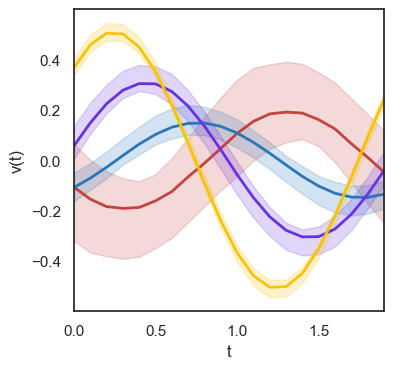

In [108]:
station_colors = [
    to_rgb("xkcd:reddish"),
    to_rgb("xkcd:bluish"),
    to_rgb("xkcd:burple"),
    to_rgb("xkcd:goldenrod"),
]

production = False
dpi = 400 if production else 100

new_f, new_ax = plt.subplots(figsize=(4, 4), dpi=dpi)
new_ax.set_xlim([0.0, 1.9])
new_ax.set_xlabel("t")
new_ax.set_ylabel("v(t)")

for i_station, confidences in enumerate(qoi_confidences):
    # axis_idx = ((i_profile // 2), (i_profile % 2))
    # axis_idx = i_profile
    credible_intervals = confidences['credible']
    model_predictions = confidences['model']
    
    # Plotting predicted intervals don't make sense
    # since its periodic in time (so we expect things to loop around)
    # predicted_intervals = confidences['prediction']

    new_ax.plot(
        time_samples,
        model_predictions,
        c=station_colors[i_station],
        lw=2,
    )
    new_ax.fill_between(
        time_samples,
        credible_intervals[0],
        credible_intervals[1],        
        color=station_colors[i_station],
        alpha=0.2
    ) 

if production:
    new_f.savefig("confidence_intervals.pdf", bbox_inches="tight")